In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import optimizers



In [27]:
class ChestXRayClassifier:
    def __init__(self, data_directory, csv_file, target_size=(299, 299), batch_size=32):
        self.data_directory = data_directory
        self.csv_file = csv_file
        self.target_size = target_size
        self.batch_size = batch_size
        self.datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
        self.model = self.build_model()
        self.early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            min_delta=0.001,
            verbose=1
        )


    def build_model(self):
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*self.target_size, 3))
        base_model.trainable = False

        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(3, activation='softmax')
        ])
        return model

    def compile_model(self):
        self.model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

    def train_model(self):
        train_generator = self.datagen.flow_from_directory(
            self.data_directory,
            batch_size=self.batch_size,
            subset='training',
            target_size=self.target_size
        )
        validation_generator = self.datagen.flow_from_directory(
            self.data_directory,
            batch_size=self.batch_size,
            subset='validation',
            target_size=self.target_size
        )
        history = self.model.fit(
            train_generator,
            epochs=30,
            validation_data=validation_generator,
            callbacks=[self.early_stopping]
        )
        return history

    def plot_history(self, history):
        # summarize history for accuracy
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

    def perform_eda(self):
        df_train = pd.read_csv(self.csv_file)
        print(df_train.head())

        # Plot the distribution of classes
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df_train, x='Label')  
        plt.title('Distribution of Classes')
        plt.show()

        # Sample a few images to display
        self.display_sample_images(df_train)

    def display_sample_images(self, df, n=5):
        sample_df = df.groupby('Label').sample(n=n, random_state=1)
        for label in df['Label'].unique():
            fig, axes = plt.subplots(1, n, figsize=(20, 5))
            fig.suptitle(f'Sample images for class: {label}')
            sample_images = sample_df[sample_df['Label'] == label]
            for ax, (_, row) in zip(axes, sample_images.iterrows()):
                image_subfolder = label.lower() 
                image_path = os.path.join(self.data_directory, image_subfolder, row['Image'])
                if not os.path.isfile(image_path):
                    print(f"File not found: {image_path}")
                    continue
                image = plt.imread(image_path)
                ax.imshow(image)
                ax.axis('off')
            plt.show()

    def evaluate_model(self, test_directory):
        datagen = ImageDataGenerator()
        test_generator = datagen.flow_from_directory(
            test_directory,
            target_size=self.target_size, 
            batch_size=self.batch_size,
            shuffle=False
        )
        
        predictions = self.model.predict(test_generator)
        predicted_labels = np.argmax(predictions, axis=1)
        true_labels = test_generator.classes
        cm = confusion_matrix(true_labels, predicted_labels)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=test_generator.class_indices.keys(),
                    yticklabels=test_generator.class_indices.keys())
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        
        print("Classification Report:\n",
              classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys()))
              


In [28]:
data_directory = 'train'  
csv_file = 'train.csv'  
test_directory = 'test'

In [10]:
classifier = ChestXRayClassifier(data_directory, csv_file, target_size=(299, 299), batch_size=32)

In [16]:
classifier.compile_model()

In [17]:
history = classifier.train_model()

Found 958 images belonging to 3 classes.
Found 238 images belonging to 3 classes.
Epoch 1/30
30/30 [==============================] - 92s 3s/step - loss: 1.1080 - accuracy: 0.3591 - val_loss: 1.1033 - val_accuracy: 0.3908
Epoch 2/30
30/30 [==============================] - 82s 3s/step - loss: 1.0991 - accuracy: 0.3695 - val_loss: 1.0851 - val_accuracy: 0.3613
Epoch 3/30
30/30 [==============================] - 83s 3s/step - loss: 1.0934 - accuracy: 0.3674 - val_loss: 1.0809 - val_accuracy: 0.3908
Epoch 4/30
30/30 [==============================] - 83s 3s/step - loss: 1.0898 - accuracy: 0.3768 - val_loss: 1.0818 - val_accuracy: 0.3908
Epoch 5/30
30/30 [==============================] - 83s 3s/step - loss: 1.0841 - accuracy: 0.3820 - val_loss: 1.0811 - val_accuracy: 0.3908
Epoch 6/30
30/30 [==============================] - 84s 3s/step - loss: 1.0833 - accuracy: 0.3685 - val_loss: 1.0818 - val_accuracy: 0.3908
Epoch 7/30
30/30 [==============================] - 84s 3s/step - loss: 1.0867

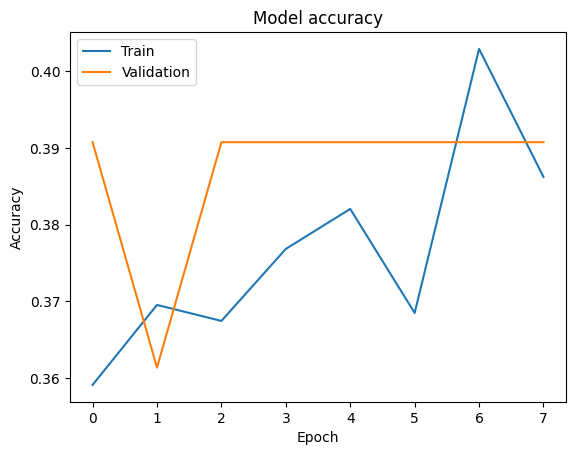

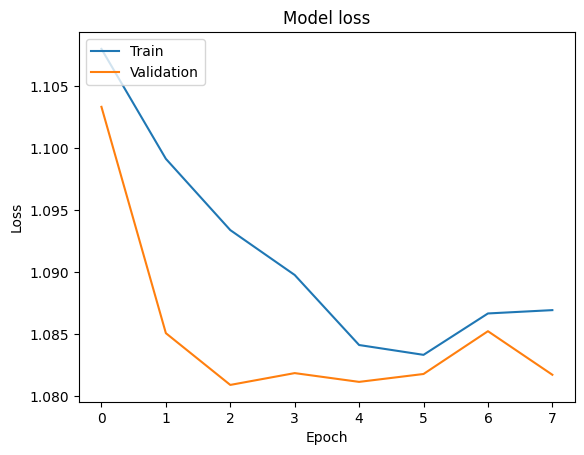

In [18]:
classifier.plot_history(history)

Found 1288 images belonging to 3 classes.


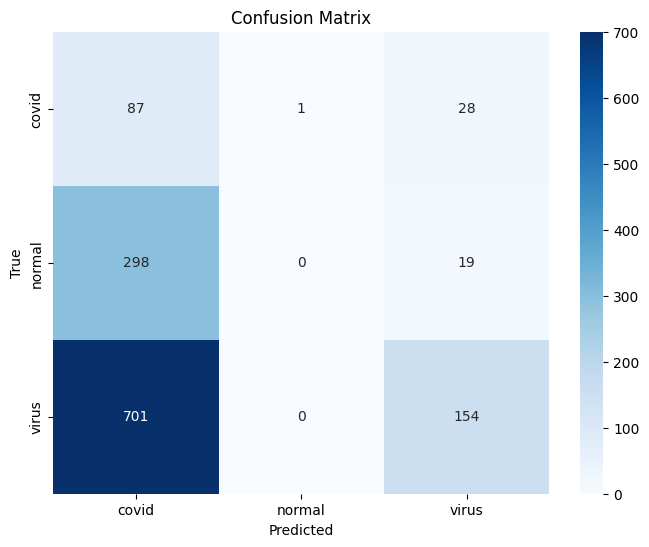

Classification Report:
               precision    recall  f1-score   support

       covid       0.08      0.75      0.14       116
      normal       0.00      0.00      0.00       317
       virus       0.77      0.18      0.29       855

    accuracy                           0.19      1288
   macro avg       0.28      0.31      0.15      1288
weighted avg       0.52      0.19      0.21      1288



In [29]:
classifier.evaluate_model(test_directory)